## Importing python libraries and starting a sas session locally on windows

In [16]:
import os
import json
from pprint import pprint
from airtable import Airtable
import pandas as pd
import saspy
sas = saspy.SASsession(cfgname='winlocal')

SAS Connection established. Subprocess id is 18940



## Set api key as a global environment variable in Windows settings
![Finding global variables](environment_variable.png)
![Setting api key for Airtable](api_key.png)

**- which database - base key**   
**- which table - yield**  
**- api key - stored locally as an environement variable in windows**

In [17]:
base_key = 'appInRX5iM5iijXuY'
table_name = 'yield'
wheat_yield = Airtable(base_key, table_name, api_key=os.environ['AIRTABLE_API_KEY'])
print(wheat_yield)

<Airtable table:yield>


## Call airtable library and get every record in the previously identified table

Stuff in parentheses after dataframe call is a mystery.  Found at https://github.com/gtalarico/airtable-python-wrapper/blob/master/Airtable.ipynb
Delete the Date/Time column because sas hates it

In [18]:
examplerecords = wheat_yield.get_all()    
wheat_yield_df = pd.DataFrame.from_records((r['fields'] for r in examplerecords))
wheat_yield_df = wheat_yield_df.drop(columns='Date/Time')

In [19]:
wheat_yield_df.head(3)

,Field 14,Moisture,Range,Row,SEQ#,Tstwght,Weight,entry,id,loc,lodging,plot,plot length (ft)
0,[USG3555],14.491,2,12,63,67.762,6.643,[recXJkbi4fuWJd8d2],G47,G,2,47,18.95
1,[GA021245-9E16],13.724,1,1,1,72.021,3.975,[recCgyI3bBI3rT72q],G1,G,4,1,18.75
2,[USG3592],0,4,19,1,0,0.732,[receXv2Ag7jxY14eL],H76,H,NaN,76,21.00


## Declare a sas libary on your local machine.  This is really just like a temp file to move data from pandas to sas.
Windows normal string vs raw string, see: https://stackoverflow.com/questions/37400974/unicode-error-unicodeescape-codec-cant-decode-bytes-in-position-2-3-trunca

In [20]:
sas.saslib('example', path=r"C:\Users\screberg\Documents\My SAS Files") 

3                                                          The SAS System                             06:36 Monday, October 21, 2019

21         
22         libname example    'C:\Users\screberg\Documents\My SAS Files'  ;
NOTE: Libref EXAMPLE was successfully assigned as follows: 
      Engine:        V9 
      Physical Name: C:\Users\screberg\Documents\My SAS Files
23         
24         


# Move data from pandas to SAS

In [21]:
sas_yield = sas.df2sd(df=wheat_yield_df,table='sas_yield',libref='example')
sas_yield.head(3)

,Field 14,Moisture,Range,Row,SEQ#,Tstwght,Weight,entry,id,loc,lodging,plot,plot length (ft)
0,['USG3555'],14.491,2,12,63,67.762,6.643,['recXJkbi4fuWJd8d2'],G47,G,2,47,18.95
1,['GA021245-9E16'],13.724,1,1,1,72.021,3.975,['recCgyI3bBI3rT72q'],G1,G,4,1,18.75
2,['USG3592'],0,4,19,1,0,0.732,['receXv2Ag7jxY14eL'],H76,H,NaN,76,21.00


## This lets us look at some basic statistics for the variable of interest  
dealing with temporary problem - all the data came in as character


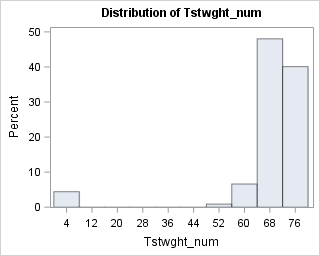

In [23]:
%%SAS
libname example 'C:\Users\screberg\Documents\My SAS Files';
data example.sas_yield; set example.sas_yield;
   Tstwght_num = input(Tstwght, 8.); run;
ods noproctitle;
ods graphics / imagemap=on;
proc univariate data=example.sas_yield; 
Var Tstwght_num;
Histogram;
run;